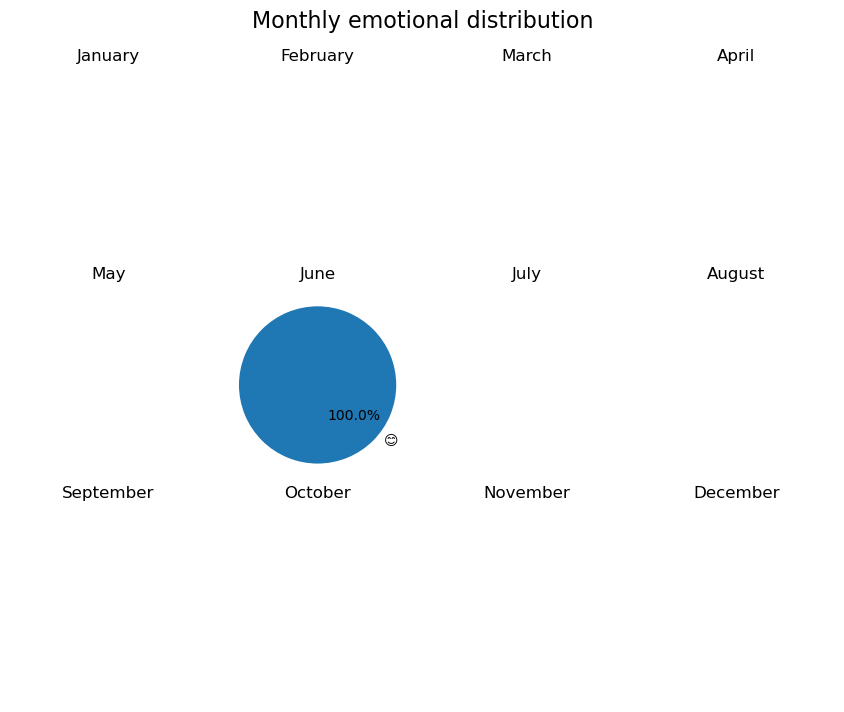

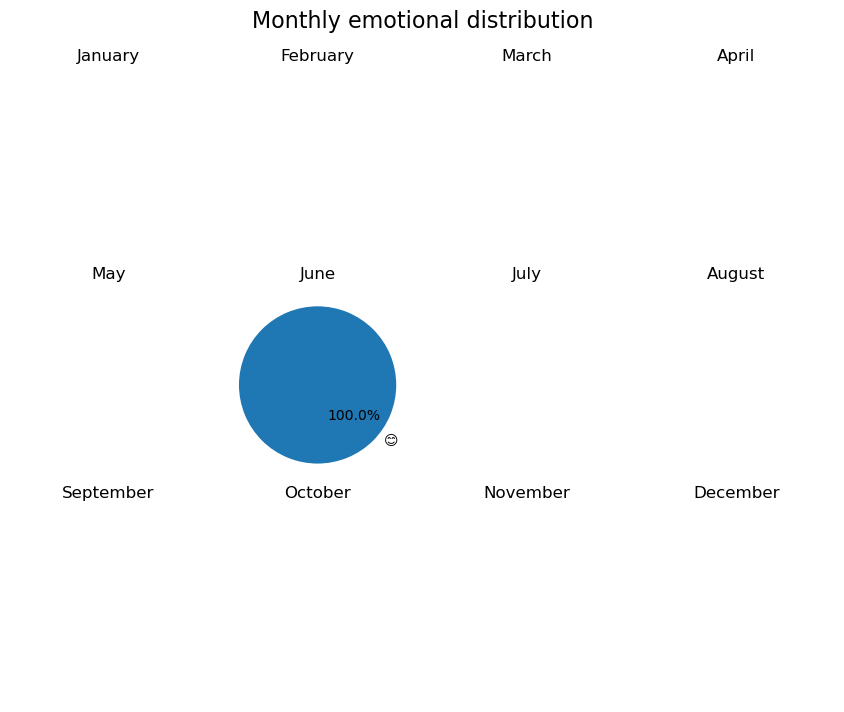

In [14]:
import sqlite3
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# 데이터베이스 연결
conn = sqlite3.connect('emotion_diary.db')
c = conn.cursor()

# 테이블 생성
c.execute('''CREATE TABLE IF NOT EXISTS users
             (username TEXT PRIMARY KEY, password TEXT)''')
c.execute('''CREATE TABLE IF NOT EXISTS entries
             (id INTEGER PRIMARY KEY AUTOINCREMENT, username TEXT, date TEXT, emotion TEXT, title TEXT, entry TEXT)''')
conn.commit()

class EmotionNoteApp:
    def __init__(self, master):
        self.master = master
        self.master.title("InsideOut")
        self.master.configure(background="white")
        self.master.geometry("850x800")

        # 메인 프레임
        self.main_frame = tk.Frame(master, bg="white")
        self.main_frame.pack(expand=True, fill="both")

        # 상단 프레임
        self.top_frame = tk.Frame(self.main_frame, bg="white")
        self.top_frame.pack(side="top", fill="x")

        # 로그인/회원가입 버튼
        self.login_button = tk.Button(self.top_frame, text="로그인", command=self.open_login_window)
        self.login_button.pack(side="left", padx=5, pady=5)
        self.register_button = tk.Button(self.top_frame, text="회원가입", command=self.open_register_window)
        self.register_button.pack(side="left", padx=5, pady=5)

        # 일기 작성 버튼 (로그인 후에만 활성화)
        self.write_button = tk.Button(self.top_frame, text="일기 작성", command=self.open_write_window, state="disabled")
        self.write_button.pack(side="left", padx=5, pady=5)

        # 검색 프레임
        self.search_frame = tk.Frame(self.top_frame, bg="white")
        self.search_frame.pack(side="right", padx=5, pady=5)

        tk.Label(self.search_frame, text="검색:", bg="white").pack(side="left")
        self.search_entry = tk.Entry(self.search_frame)
        self.search_entry.pack(side="left", padx=5)
        self.search_button = tk.Button(self.search_frame, text="검색", command=self.perform_search, state="disabled")
        self.search_button.pack(side="left", padx=5)

        # 로그인 상태 변수
        self.logged_in = False
        self.username = None

        # 하단 탭 프레임 (로그인 후에만 활성화)
        self.bottom_frame = tk.Frame(self.main_frame, bg="white")
        self.bottom_frame.pack(side="bottom", fill="x")

        self.entry_list_flipper_button = tk.Button(self.bottom_frame, text="일기 목록", command=self.show_entry_list, width=29, height=1, font=("Arial", 12), bg="#B5E3D5", state="disabled")
        self.entry_list_flipper_button.pack(side="left", padx=5, pady=5)

        self.calendar_flipper_button = tk.Button(self.bottom_frame, text="달력", command=self.show_calendar, width=29, height=1, font=("Arial", 12), bg="#B5E3D5", state="disabled")
        self.calendar_flipper_button.pack(side="left", padx=5, pady=5)

        self.stats_flipper_button = tk.Button(self.bottom_frame, text="통계", command=self.show_statistics, width=29, height=1, font=("Arial", 12), bg="#B5E3D5", state="disabled")
        self.stats_flipper_button.pack(side="right", padx=5, pady=5)

        # 현재 선택된 탭을 추적하기 위한 변수
        self.current_tab = "entry_list"

        # 감정 목록 표시
        self.entry_listbox = tk.Listbox(self.main_frame, width=70, height=20, font=("Arial", 12), bg="#ffffb7")
        self.entry_listbox.pack(padx=10, pady=5, side="top", fill="both")
        self.entry_listbox.bind("<<ListboxSelect>>", self.show_entry_details)

        # 달력 프레임
        self.calendar_frame = tk.Frame(self.main_frame, bg="white")

        # 통계 프레임
        self.stats_frame = tk.Frame(self.main_frame, bg="white")

    def open_login_window(self):
        login_window = tk.Toplevel(self.master)
        login_window.title("로그인")
        login_window.configure(background="white")

        # 로그인 프레임
        login_frame = tk.Frame(login_window, bg="white")
        login_frame.pack(padx=10, pady=10)

        # 사용자 이름 입력
        username_frame = tk.Frame(login_frame, bg="white")
        username_frame.pack(pady=(0, 10), fill="both")
        tk.Label(username_frame, text="사용자 이름:", bg="white", font=("Arial", 12)).pack(side="left", padx=5)
        username_entry = tk.Entry(username_frame, font=("Arial", 12))
        username_entry.pack(side="right", padx=5)

        # 비밀번호 입력
        password_frame = tk.Frame(login_frame, bg="white")
        password_frame.pack(pady=(0, 10), fill="both")
        tk.Label(password_frame, text="비밀번호:", bg="white", font=("Arial", 12)).pack(side="left", padx=5)
        password_entry = tk.Entry(password_frame, show="*", font=("Arial", 12))
        password_entry.pack(side="right", padx=5)

        # 로그인 버튼
        login_button = tk.Button(login_frame, text="로그인", command=lambda: self.login(username_entry.get(), password_entry.get(), login_window))
        login_button.pack(pady=(10, 0))

    def open_register_window(self):
        register_window = tk.Toplevel(self.master)
        register_window.title("회원가입")
        register_window.configure(background="white")

        # 회원가입 프레임
        register_frame = tk.Frame(register_window, bg="white")
        register_frame.pack(padx=10, pady=10)

        # 사용자 이름 입력
        username_frame = tk.Frame(register_frame, bg="white")
        username_frame.pack(pady=(0, 10), fill="both")
        tk.Label(username_frame, text="사용자 이름:", bg="white", font=("Arial", 12)).pack(side="left", padx=5)
        username_entry = tk.Entry(username_frame, font=("Arial", 12))
        username_entry.pack(side="right", padx=5)
        # 비밀번호 입력
        password_frame = tk.Frame(register_frame, bg="white")
        password_frame.pack(pady=(0, 10), fill="both")
        tk.Label(password_frame, text="비밀번호:", bg="white", font=("Arial", 12)).pack(side="left", padx=5)
        password_entry = tk.Entry(password_frame, show="*", font=("Arial", 12))
        password_entry.pack(side="right", padx=5)
    
        # 회원가입 버튼
        register_button = tk.Button(register_frame, text="회원가입", command=lambda: self.register(username_entry.get(), password_entry.get(), register_window))
        register_button.pack(pady=(10, 0))
    
    def login(self, username, password, login_window):
        c.execute("SELECT * FROM users WHERE username=? AND password=?", (username, password))
        user = c.fetchone()
        if user:
            self.logged_in = True
            self.username = username
            self.enable_app()
            login_window.destroy()
            messagebox.showinfo("로그인 성공", f"{username}님, 환영합니다!")
        else:
            messagebox.showerror("로그인 실패", "잘못된 사용자 이름 또는 비밀번호입니다.")
    
    def register(self, username, password, register_window):
        c.execute("SELECT * FROM users WHERE username=?", (username,))
        user = c.fetchone()
        if user:
            messagebox.showerror("회원가입 실패", "이미 존재하는 사용자 이름입니다.")
        else:
            c.execute("INSERT INTO users (username, password) VALUES (?, ?)", (username, password))
            conn.commit()
            messagebox.showinfo("회원가입 성공", "회원가입이 완료되었습니다.")
            register_window.destroy()
    
    def enable_app(self):
        self.write_button.config(state="normal")
        self.search_button.config(state="normal")
        self.entry_list_flipper_button.config(state="normal")
        self.calendar_flipper_button.config(state="normal")
        self.stats_flipper_button.config(state="normal")
        self.refresh_entry_list()

    def show_entry_details(self, event):
        selection = self.entry_listbox.curselection()
        if selection:
            index = selection[0]
            entry_details = self.get_entry_details(index)
            if entry_details:
                self.show_entry_window(entry_details)

    def get_entry_details(self, index):
        c.execute("SELECT id, date, emotion, title, entry FROM entries WHERE username=? ORDER BY date DESC", (self.username,))
        entries = c.fetchall()
        if 0 <= index < len(entries):
            entry_id, date, emotion, title, entry = entries[index]
            return date, emotion, title, entry
        else:
            messagebox.showerror("오류", "선택한 인덱스가 유효하지 않습니다.")
        return None
        
    def show_entry_list(self):
        if self.current_tab != "entry_list":
            self.calendar_frame.pack_forget()  # 달력 프레임 감추기
            self.stats_frame.pack_forget()  # 통계 프레임 감추기
            self.entry_listbox.pack(side="top", fill="both")
            self.search_frame.pack(side="right", padx=5, pady=5)  # 검색 프레임 표시
            self.current_tab = "entry_list"
    
    def show_calendar(self):
        if self.current_tab != "calendar":
            self.entry_listbox.pack_forget()  # 일기 목록 감추기
            self.stats_frame.pack_forget()  # 통계 프레임 감추기
            self.search_frame.pack_forget()  # 검색 프레임 감추기
            self.display_calendar()
            self.calendar_frame.pack(side="top", fill="both")
            self.current_tab = "calendar"

    def show_statistics(self):
        if self.current_tab != "statistics":
            self.entry_listbox.pack_forget()  # 일기 목록 감추기
            self.calendar_frame.pack_forget()  # 달력 프레임 감추기
            self.search_frame.pack_forget()  # 검색 프레임 감추기
            self.display_statistics()
            self.stats_frame.pack(side="top", fill="both")
            self.current_tab = "statistics"
    
    def refresh_entry_list(self):
        self.entry_listbox.delete(0, tk.END)
        c.execute("SELECT id, date, emotion, title FROM entries WHERE username=? ORDER BY date DESC", (self.username,))
        entries = c.fetchall()
        for idx, entry in enumerate(entries, start=1):
            entry_id, date, emotion, title = entry
            self.entry_listbox.insert(tk.END, f"{idx}. {title} ({date}) {emotion}")
    
    def perform_search(self):
        keyword = self.search_entry.get().strip()
        if not keyword:
            self.refresh_entry_list()
            return
    
        self.entry_listbox.delete(0, tk.END)
        c.execute("SELECT id, date, emotion, title FROM entries WHERE username=? AND (date LIKE ? OR emotion LIKE ? OR title LIKE ? OR entry LIKE ?) ORDER BY date DESC", (self.username, f"%{keyword}%", f"%{keyword}%", f"%{keyword}%", f"%{keyword}%"))
        entries = c.fetchall()
        for idx, entry in enumerate(entries, start=1):
            entry_id, date, emotion, title = entry
            self.entry_listbox.insert(tk.END, f"{idx}. {title} ({date}) {emotion}")
    
    def open_write_window(self):
        write_window = tk.Toplevel(self.master)
        write_window.title("일기 작성")
        write_window.configure(background="white")

        # 일기 작성 프레임
        write_frame = tk.Frame(write_window, bg="white")
        write_frame.pack(padx=10, pady=10)

        # 감정 선택 프레임
        emotion_frame = tk.Frame(write_frame, bg="white")
        emotion_frame.pack(pady=(0, 10), fill="both")

        tk.Label(emotion_frame, text="오늘의 감정을 선택하세요:", bg="white").pack(side="left", padx=5)
        emotion_icons = ["😊", "😢", "😡", "😖", "😐"]
        selected_emotion = tk.StringVar()
        selected_emotion.set(emotion_icons[-1])  # Default: 중립
        for icon in emotion_icons:
            tk.Radiobutton(emotion_frame, text=icon, variable=selected_emotion, value=icon, bg="white", font=("Arial", 20)).pack(side="left")

        # 제목 입력
        title_frame = tk.Frame(write_frame, bg="white")
        title_frame.pack(pady=(0, 10), fill="both")
        tk.Label(title_frame, text="제목:", bg="white", font=("Arial", 12)).pack(side="left", padx=5)
        entry_title = tk.Entry(title_frame, width=60, font=("Arial", 12))
        entry_title.pack(side="right", padx=5)

        # 내용 입력
        content_frame = tk.Frame(write_frame, bg="white")
        content_frame.pack(fill="both")
        tk.Label(content_frame, text="일기 내용:", bg="white", font=("Arial", 12)).pack(side="top", padx=5)
        entry_text = tk.Text(content_frame, height=20, width=80, font=("Arial", 12))
        entry_text.pack(padx=5, pady=5)

        # 저장 버튼
        save_button = tk.Button(write_frame, text="저장", command=lambda: self.save_entry(selected_emotion.get(), entry_title.get(), entry_text.get("1.0", tk.END).strip(), write_window))
        save_button.pack(pady=(10, 0))

    
    def save_entry(self, emotion, title, entry, write_window):
        date = datetime.now().strftime("%Y년 %m월 %d일")
        c.execute("INSERT INTO entries (username, date, emotion, title, entry) VALUES (?, ?, ?, ?, ?)", (self.username, date, emotion, title, entry))
        conn.commit()
        messagebox.showinfo("저장 완료", "일기가 저장되었습니다.")
        self.refresh_entry_list()
        write_window.destroy()
    
    def get_entry_details(self, index):
        c.execute("SELECT id, date, emotion, title, entry FROM entries WHERE username=? ORDER BY date DESC", (self.username,))
        entries = c.fetchall()
        if 0 <= index < len(entries):
            entry_id, date, emotion, title, entry = entries[index]
            return date, emotion, title, entry
        else:
            messagebox.showerror("오류", "선택한 인덱스가 유효하지 않습니다.")
        return None
    
    def show_entry_window(self, entry_details):
        entry_window = tk.Toplevel(self.master)
        entry_window.title("일기 보기")
        entry_window.configure(background="white")

        date, emotion, title, entry = entry_details

        # 일기 보기 프레임
        view_frame = tk.Frame(entry_window, bg="white")
        view_frame.pack(padx=10, pady=10)

        # 감정 표시
        emotion_label = tk.Label(view_frame, text=emotion, font=("Arial", 20), bg="white")
        emotion_label.pack(pady=(0, 10))

        # 제목 표시
        title_label = tk.Label(view_frame, text=title, font=("Arial", 14, "bold"), bg="white")
        title_label.pack(pady=(0, 10))

        # 날짜 표시
        date_label = tk.Label(view_frame, text=date, font=("Arial", 12), bg="white")
        date_label.pack(pady=(0, 10))

        # 내용 표시
        content_frame = tk.Frame(view_frame, bg="white")
        content_frame.pack(fill="both")
        content_text = tk.Text(content_frame, height=15, width=70, font=("Arial", 12))
        content_text.insert(tk.END, entry)
        content_text.config(state="disabled")
        content_text.pack(padx=5, pady=5)
        # 수정 버튼
        edit_button = tk.Button(view_frame, text="수정", command=lambda: self.edit_entry(entry_window, entry_details))
        edit_button.pack(side="left", padx=5, pady=10)
    
        # 삭제 버튼
        delete_button = tk.Button(view_frame, text="삭제", command=lambda: self.delete_entry(entry_details))
        delete_button.pack(side="left", padx=5, pady=10)

    
    def edit_entry(self, entry_window, entry_details):
        date, emotion, title, entry = entry_details
        edit_window = tk.Toplevel(self.master)
        edit_window.title("일기 수정")
        edit_window.configure(background="white")

        edit_window.geometry("800x600")
    
        # 일기 수정 프레임
        edit_frame = tk.Frame(edit_window, bg="white")
        edit_frame.pack(padx=10, pady=10)
    
        # 감정 선택 프레임
        emotion_frame = tk.Frame(edit_frame, bg="white")
        emotion_frame.pack(pady=(0, 10), fill="both")
    
        tk.Label(emotion_frame, text="감정을 선택하세요:", bg="white").pack(side="left", padx=5)
        emotion_icons = ["😊", "😢", "😡", "😖", "😐"]
        selected_emotion = tk.StringVar()
        selected_emotion.set(emotion)
        for icon in emotion_icons:
            tk.Radiobutton(emotion_frame, text=icon, variable=selected_emotion, value=icon, bg="white", font=("Arial", 20)).pack(side="left")
    
        # 제목 입력
        title_frame = tk.Frame(edit_frame, bg="white")
        title_frame.pack(pady=(0, 10), fill="both")
        tk.Label(title_frame, text="제목:", bg="white", font=("Arial", 12)).pack(side="left", padx=5)
        entry_title = tk.Entry(title_frame, width=60, font=("Arial", 12))
        entry_title.insert(0, title)
        entry_title.pack(side="right", padx=5)
    
        # 내용 입력
        content_frame = tk.Frame(edit_frame, bg="white")
        content_frame.pack(fill="both")
        tk.Label(content_frame, text="일기 내용:", bg="white", font=("Arial", 12)).pack(side="top", padx=5)
        entry_text = tk.Text(content_frame, height=20, width=80, font=("Arial", 12))
        entry_text.insert(tk.END, entry)
        entry_text.pack(padx=5, pady=5)
    
        # 저장 버튼
        save_button = tk.Button(edit_frame, text="저장", command=lambda: self.update_entry(entry_details, selected_emotion.get(), entry_title.get(), entry_text.get("1.0", tk.END).strip(), entry_window, edit_window))
        save_button.pack(pady=(10, 0))
    
    def update_entry(self, entry_details, emotion, title, entry, entry_window, edit_window):
        date = entry_details[0]
        entry_id = c.execute("SELECT id FROM entries WHERE username=? AND date=? AND emotion=? AND title=? AND entry=?", (self.username, date, entry_details[1], entry_details[2], entry_details[3])).fetchone()[0]
        c.execute("UPDATE entries SET emotion=?, title=?, entry=? WHERE id=?", (emotion, title, entry, entry_id))
        conn.commit()
        messagebox.showinfo("수정 완료", "일기가 수정되었습니다.")
        entry_window.destroy()
        edit_window.destroy()
        self.refresh_entry_list()
    
    def delete_entry(self, entry_details):
        confirmed = messagebox.askyesno("일기 삭제", "정말로 이 일기를 삭제하시겠습니까?")
        if confirmed:
            date, emotion, title, entry = entry_details
            entry_id = c.execute("SELECT id FROM entries WHERE username=? AND date=? AND emotion=? AND title=? AND entry=?", (self.username, date, emotion, title, entry)).fetchone()[0]
            c.execute("DELETE FROM entries WHERE id=?", (entry_id,))
            conn.commit()
            messagebox.showinfo("삭제 완료", "일기가 삭제되었습니다.")
            self.refresh_entry_list()
    
    def display_calendar(self, year=None, month=None):
        # 달력 프레임 초기화
        for widget in self.calendar_frame.winfo_children():
            widget.destroy()
    
        # 현재 날짜 가져오기
        if year is None and month is None:
            today = datetime.now()
            year, month = today.year, today.month
    
        # 달력 생성
        calendar_frame = tk.Frame(self.calendar_frame, bg="white")
        calendar_frame.pack(padx=10, pady=20)  # 달력 전체를 아래쪽으로 이동
    
        # 월 표시 및 이전/다음 달 버튼
        month_frame = tk.Frame(calendar_frame, bg="white")
        month_frame.grid(row=0, column=0, columnspan=7, pady=(0, 10))
    
        prev_month_button = tk.Button(month_frame, text="<", font=("Arial", 14), command=lambda: self.display_calendar(year, month - 1))
        prev_month_button.pack(side="left", padx=5)
    
        month_label = tk.Label(month_frame, text=f"{year}년 {month}월", font=("Arial", 18, "bold"), bg="white")
        month_label.pack(side="left", padx=5)
    
        next_month_button = tk.Button(month_frame, text=">", font=("Arial", 14), command=lambda: self.display_calendar(year, month + 1))
        next_month_button.pack(side="left", padx=5)
    
        # 요일 표시
        weekday_labels = []
        for col, weekday in enumerate(["일", "월", "화", "수", "목", "금", "토"]):
            label = tk.Label(calendar_frame, text=weekday, font=("Arial", 14), width=5, height=2, bg="white")
            label.grid(row=1, column=col)
            weekday_labels.append(label)
    
        # 달력 셀 생성
        cal = calendar.monthcalendar(year, month)
        row = 2
        for week in cal:
            col = 0
            for day in week:
                date_str = f"{year}년 {month:02d}월 {day:02d}일"
                try:
                    with open("emotions.txt", "r", encoding="utf-8") as file:
                        emotion = ""
                        for line in file:
                            if line.startswith(f"Date: {date_str}"):
                                emotion = line.split(",")[1].split(":")[1].strip()
                                break
                except Exception as e:
                    messagebox.showerror("오류", f"파일을 읽는 중 오류가 발생했습니다: {e}")
    
                day_label = tk.Label(calendar_frame, text=str(day) if day else "", font=("Arial", 14), width=5, height=2, bg="#aee5f9", borderwidth=1, relief="solid")
                day_label.grid(row=row, column=col, padx=1, pady=1)
    
                emotion_label = tk.Label(calendar_frame, text=emotion, font=("Arial", 12), width=6, height=2, bg="white", borderwidth=1, relief="solid")
                emotion_label.grid(row=row+1, column=col, padx=1, pady=1)
    
                col += 1
            row += 2
    def get_emotion_for_date(self, date_str):
        try:
            with open("emotions.txt", "r", encoding="utf-8") as file:
                for line in file:
                    if line.startswith(f"Date: {date_str}"):
                        emotion = line.split(",")[1].split(":")[1].strip()
                        return emotion
        except Exception as e:
            messagebox.showerror("오류", f"파일을 읽는 중 오류가 발생했습니다: {e}")
    
        return ""
    
    def display_statistics(self):
        if self.current_tab != "statistics":
            self.entry_listbox.pack_forget()  # 일기 목록 감추기
            self.calendar_frame.pack_forget()  # 달력 프레임 감추기
            self.search_frame.pack_forget()  # 검색 프레임 감추기
            self.refresh_entry_list()  # 일기 목록 갱신
    
            monthly_emotions = {i: [] for i in range(1, 13)}
    
            c.execute("SELECT date, emotion FROM entries WHERE username=?", (self.username,))
            entries = c.fetchall()
            for entry in entries:
                date, emotion = entry
                month = int(date.split("년")[1].split("월")[0].strip())
                monthly_emotions[month].append(emotion)
            if hasattr(self, "stats_frame"):
                self.stats_frame.destroy()  # 기존 통계 프레임 제거

            self.stats_frame = tk.Frame(self.main_frame, bg="white")
            self.stats_frame.pack(fill="both", expand=True)
    
            fig, axs = plt.subplots(3, 4, figsize=(10, 8), sharex=True, sharey=True)
            fig.suptitle('Monthly emotional distribution', fontsize=16)
    
            for i, (month, emotions) in enumerate(monthly_emotions.items()):
                emotion_count = {emotion: emotions.count(emotion) for emotion in set(emotions)}
                labels = list(emotion_count.keys())
                counts = list(emotion_count.values())
    
                axs[i // 4, i % 4].pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
                axs[i // 4, i % 4].set_title(calendar.month_name[month], fontsize=12)
    
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
    
            # 이미지를 표시하기 위해 Tkinter용 캔버스 생성
            canvas = FigureCanvasTkAgg(fig, master=self.stats_frame)
            canvas.draw()
            canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
            self.current_tab = "statistics"

if __name__ == "__main__":
    root = tk.Tk()
    app = EmotionNoteApp(root)
    root.mainloop()
    conn.close()
